#### Домашнее задание к занятию "Элементарные алгоритмы обработки временных рядов"

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

Для анализа возьмем значения фондового индекса Dow Jones к закрытию торгов

In [2]:
series = pd.read_csv("C:/Users/gogol/Desktop/Netology/I work in this folder/Блок 4 Машинное обучение/17 Знакомство с временными рядами/Series/weekly-closings-of-the-dowjones-.csv")['Close']

#### 1. Сглаживание нестационарного ряда

Напишем функцию скользящего среднего, но с небольшой модификацией (center=True), которая устраняет отставание от несглаженного ряда

In [3]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n, center=True).mean()

Напишем функцию взвешенного скользящего среднего

In [4]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

Напишем функцию экспоненциального сглаживания

In [5]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Посмотрим, как изменится ряд

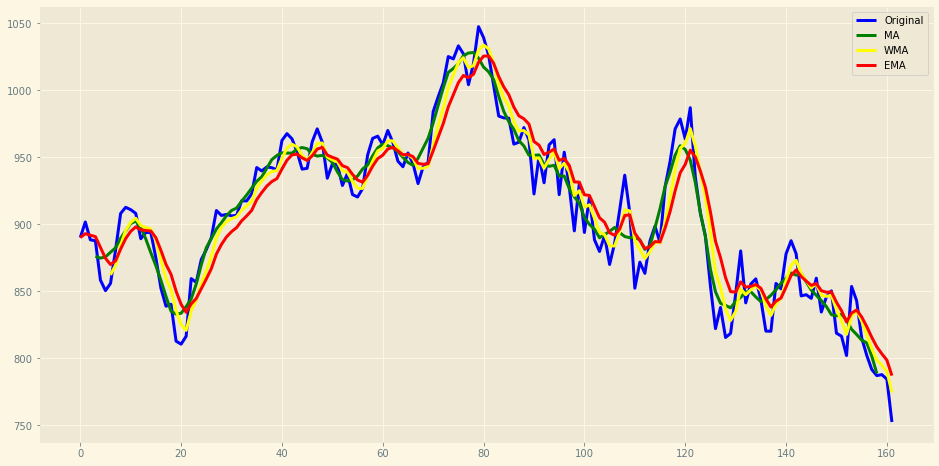

In [6]:
ma = moving_average(series, 7)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ema = exponential_moving_average(series, 0.25)

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(16, 8))
    plt.plot(series, color='blue', linewidth='3', label='Original')
    plt.plot(ma, color='green', linewidth='3', label='MA')
    plt.plot(wma, color='yellow', linewidth='3', label='WMA')
    plt.plot(ema, color='red', linewidth='3', label='EMA')
    plt.legend()

Функция для предсказания ряда на основе МА

In [7]:
def predict_ma(series, window, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-window:].mean()]), ignore_index=True)
    return new_series

Функция для предсказания ряда на основе WМА

In [8]:
def predict_wma(series, window, n_pred, weights):
    new_series = series.copy()
    weights = np.array(weights)
    for _ in range(n_pred):
        s = np.array(new_series[-window:])
        new_series = new_series.append(pd.Series((s * weights).sum() / weights.sum()), ignore_index=True)
    return new_series

Функция для предсказания ряда на основе ЕМА

In [9]:
def predict_ema(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1]) #изменение относительно лекции: не series[n-1], а series[n]
    if not n_pred:
        return pd.Series(result)
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred-1):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

Отобразим результат исполнения функций

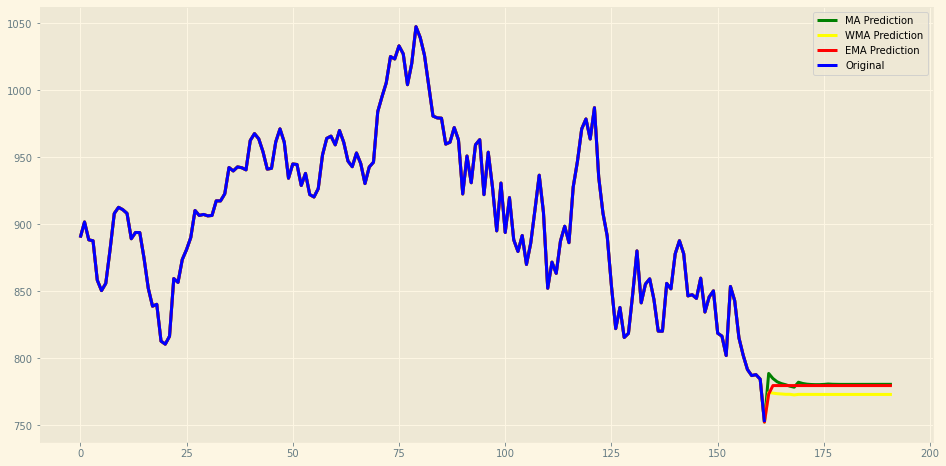

In [10]:
ma_prediction = predict_ma(series, 7, 30)
wma_prediction = predict_wma(series, 7, 30, [1,1,2,3,5,8,13])
ema_prediction = predict_ema(series, 0.3, n_pred=30)[0]

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(16, 8))
    plt.plot(ma_prediction, color='green', linewidth='3', label='MA Prediction')
    plt.plot(wma_prediction, color='yellow', linewidth='3', label='WMA Prediction')
    plt.plot(ema_prediction, color='red', linewidth='3', label='EMA Prediction')
    plt.plot(series, color='blue', linewidth='3', label='Original')
    plt.legend()

#### 2. Сглаживание стационарного ряда

Предварительно напишем функцию тестирования ряда на стационарность

In [11]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

И функцию для наглядного визуального отображения

In [12]:
def tsplot(y, lags=None, figsize=(14, 8), style='Solarize_Light2'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Поскольку в прошлом домашнем задании уже были графически отображены все шаги преобразования ряда в стационарный, здесь приведем только формулы и не будем загромождать этот ноутбук лишними графиками.

Уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [13]:
stationary_series = boxcox(series, 0)

Убираем тренды путем дифференцирования

In [14]:
stationary_series = stationary_series[1:] - stationary_series[:-1]

Посмотрим на результат. Здесь тест Дики-Фуллера отвергает гипотезу о нестационарности ряда. С этим стационраным рядом и будем работать дальше

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


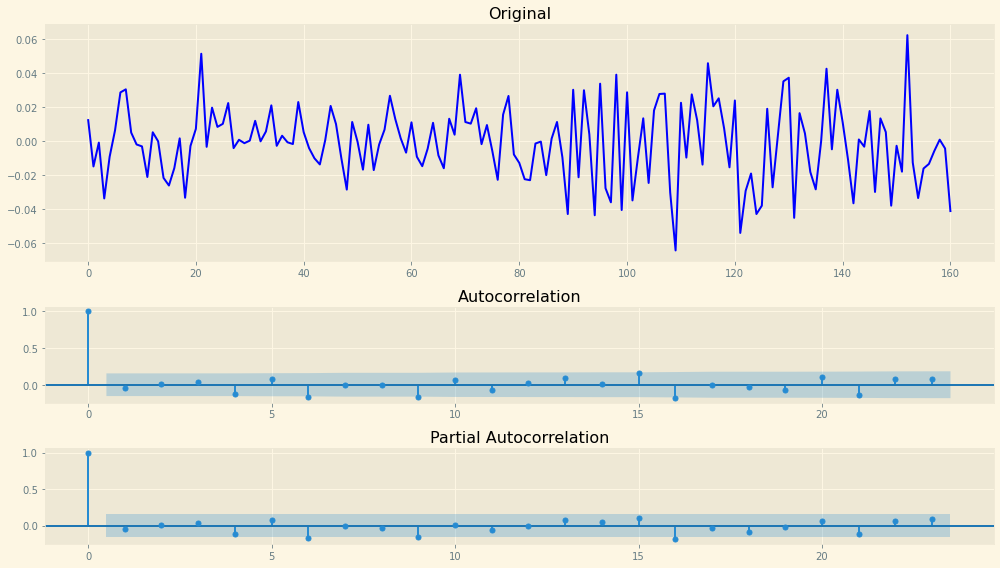

In [15]:
tsplot(stationary_series)

Для графического отображения сглаживания полученного стационарного ряда воспользуемя функциями, написанными в первой части домашнего задания

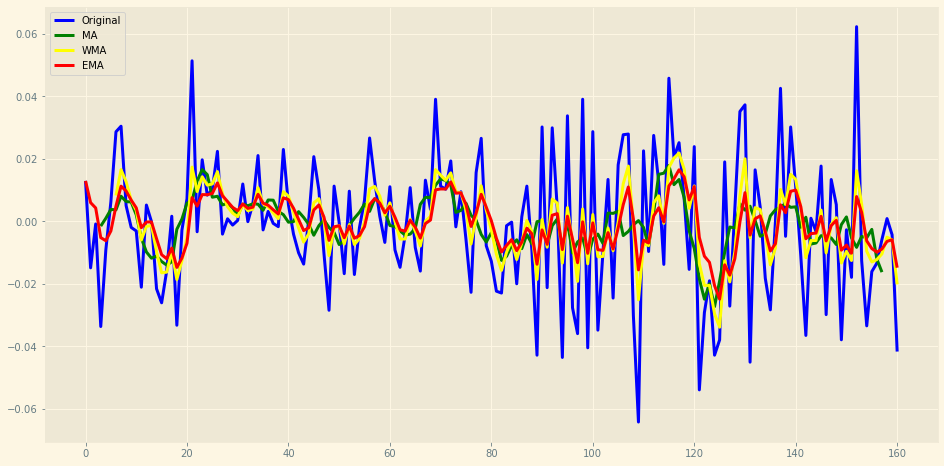

In [16]:
ma_st = moving_average(stationary_series, 7)
wma_st = weighted_moving_average(stationary_series, 7, [1,1,2,3,5,8,13])
ema_st = exponential_moving_average(stationary_series, 0.25)

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(16, 8))
    plt.plot(stationary_series, color='blue', linewidth='3', label='Original')
    plt.plot(ma_st, color='green', linewidth='3', label='MA')
    plt.plot(wma_st, color='yellow', linewidth='3', label='WMA')
    plt.plot(ema_st, color='red', linewidth='3', label='EMA')
    plt.legend()

Далее воспользуемся функциями для предсказания ряда

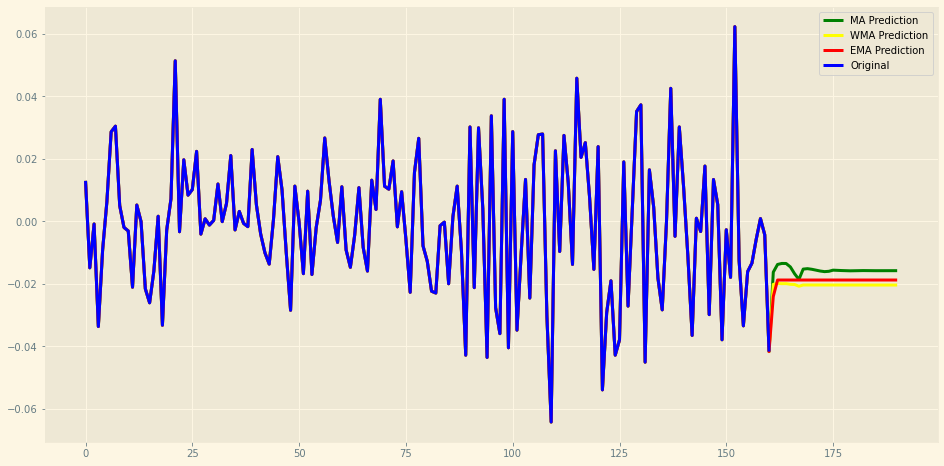

In [17]:
ma_st_prediction = predict_ma(pd.Series(stationary_series), 7, 30)
wma_st_prediction = predict_wma(pd.Series(stationary_series), 7, 30, [1,1,2,3,5,8,13])
ema_st_prediction = predict_ema(pd.Series(stationary_series), 0.3, n_pred=30)[0]

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(16, 8))
    plt.plot(ma_st_prediction, color='green', linewidth='3', label='MA Prediction')
    plt.plot(wma_st_prediction, color='yellow', linewidth='3', label='WMA Prediction')
    plt.plot(ema_st_prediction, color='red', linewidth='3', label='EMA Prediction')
    plt.plot(stationary_series, color='blue', linewidth='3', label='Original')
    plt.legend()

Выбранные для сглаживания модели (MA, WMA и EMA) на данном ряду дают примерно равные результаты. В этом случае большую значимость играют такие параметры как окно (window), веса (weights) и сглаживающий фактор (alpha). Именно их изменение оказывает наибольшеее влияние на результат